# GAN + MINE example

In [1]:
import sys
sys.path.append("../python")

In [2]:
import numpy as np

In [3]:
import torch
import torchmine
import torchvision

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [5]:
from tqdm import tqdm

In [6]:
from misc.modules import *
from misc.plots import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g2w9ocb9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [7]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "GAN/MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "resuts/"

## Dataset

In [8]:
from torchvision.datasets import MNIST

In [9]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [10]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [11]:
batch_size_train = 1024
batch_size_test  = 1024

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

## Models

In [13]:
latent_dim = 32

In [14]:
class Generator(torch.nn.Module):
    """
    MNIST-generator.
    """
    
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        
        # Activations.
        self.activation = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        # Convolution layers.
        self.conv2d_1 = torch.nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(64, 32, kernel_size=3, padding='same', padding_mode='reflect')
        self.conv2d_3 = torch.nn.Conv2d(32, 1, kernel_size=3, padding='same', padding_mode='reflect')
        
        self.upsample = torch.nn.Upsample(scale_factor=2)
        
        # Dense layers.
        self.linear_1 = torch.nn.Linear(latent_dim, 256)
        self.linear_2 = torch.nn.Linear(256, 7*7*128)
        
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense layer №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)
        
        # Dense layer №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)
        
        # Convolution layer №1
        x = torch.reshape(layer_2, (-1, 128, 7, 7))
        x = self.conv2d_1(x)
        x = self.upsample(x)
        layer_3 = self.activation(x)
        
        # Convolution layer №2
        x = self.conv2d_2(layer_3)
        x = self.upsample(x)
        layer_4 = self.activation(x)
        
        # Convolution layer №3
        x = self.conv2d_3(layer_4)
        layer_5 = self.sigmoid(x)
        
        return layer_5

In [15]:
class Discriminator(torch.nn.Module):
    """
    Convolutional discriminator.
    """
    
    def __init__(self) -> None:
        super().__init__()
        
        # Noise.
        self.dropout = torch.nn.Dropout(0.1)
        
        # Activations.
        self.activation = torch.nn.LeakyReLU()
        
        # Convolution layers.
        self.conv2d_1 = torch.nn.utils.parametrizations.spectral_norm(torch.nn.Conv2d(1, 32, kernel_size=3), n_power_iterations=10)
        self.conv2d_2 = torch.nn.utils.parametrizations.spectral_norm(torch.nn.Conv2d(32, 64, kernel_size=3), n_power_iterations=10)
        self.conv2d_3 = torch.nn.utils.parametrizations.spectral_norm(torch.nn.Conv2d(64, 128, kernel_size=3), n_power_iterations=10)
        self.pool2d = torch.nn.AvgPool2d((2,2))
        
        self.batchnorm2d_1 = torch.nn.BatchNorm2d(32)
        self.batchnorm2d_2 = torch.nn.BatchNorm2d(64)
        self.batchnorm2d_3 = torch.nn.BatchNorm2d(128)
        
        # Dense layers.
        self.linear_1 = torch.nn.utils.parametrizations.spectral_norm(torch.nn.Linear(128, 128), n_power_iterations=10)
        self.linear_2 = torch.nn.utils.parametrizations.spectral_norm(torch.nn.Linear(128, 1), n_power_iterations=10)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution layer №1
        #x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.pool2d(x)
        x = self.activation(x)
        x = self.batchnorm2d_1(x)
        
        # Convolution layer №2
        #x = self.dropout(x)
        x = self.conv2d_2(x)
        x = self.pool2d(x)
        x = self.activation(x)
        x = self.batchnorm2d_2(x)
        
        # Convolution layer №3
        #x = self.dropout(x)
        x = self.conv2d_3(x)
        x = self.pool2d(x)
        x = self.activation(x)
        x = self.batchnorm2d_3(x)
        
        # Dense layer №1
        x = self.linear_1(torch.flatten(x, 1))
        x = self.activation(x)
        
        # Dense layer №2
        x = self.linear_2(x)
        
        return x

In [16]:
class GANT(NeuralT):
    """
    T-statistics neural network.
    """
    
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        
        # Activations.
        self.activation = torch.nn.LeakyReLU()
        
        # Convolution layers.
        self.conv2d_1 = torch.nn.Conv2d(1, 16, kernel_size=3)
        self.conv2d_2 = torch.nn.Conv2d(16, 32, kernel_size=3)
        self.conv2d_3 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.pool2d = torch.nn.AvgPool2d((2,2))
        
        # Dense layers.
        self.linear_1 = torch.nn.Linear(64, self.latent_dim)
        self.linear_2 = torch.nn.Linear(2*self.latent_dim, 64)
        self.linear_3 = torch.nn.Linear(64, 1)


    def forward(self, x: torch.tensor, y: torch.tensor, permute: bool=False) -> torch.tensor:
        if permute:
            x = x[torch.randperm(x.shape[0])]
            
        # Convolution layer №1
        y = self.conv2d_1(y)
        y = self.pool2d(y)
        y = self.activation(y)
        
        # Convolution layer №2
        y = self.conv2d_2(y)
        y = self.pool2d(y)
        y = self.activation(y)
        
        # Convolution layer №3
        y = self.conv2d_3(y)
        y = self.pool2d(y)
        y = self.activation(y)
        
        # Dense layer №1
        y = self.linear_1(torch.flatten(y, 1))
        y = self.activation(y)
        
        layer = torch.cat((x, y), dim=1)
        
        # Dense layer №2
        layer = self.linear_2(layer)
        layer = self.activation(layer)
        
        # Dense layer №3
        layer = self.linear_3(layer)
        
        return layer

In [17]:
generator_model = Generator(latent_dim).to(device)
discriminator_model = Discriminator().to(device)
gan_t_model = GANT(latent_dim).to(device)

In [33]:
def plot_images(generator_model, device, n_rows=1, n_columns=8):
    was_in_training = generator_model.training
    generator_model.eval()
    
    with torch.no_grad():
        images_cnt = n_rows * n_columns
        noise = torch.randn((images_cnt, generator_model.latent_dim), device=device, requires_grad=False)
        generated = generator_model(noise)

        plt.figure(figsize=(4*n_columns, 4*n_rows))
        for index in range(images_cnt):
            ax = plt.subplot(n_rows,n_columns,1*index+1)
            ax.imshow(np.clip(generated[index].detach().cpu().numpy().transpose(1,2,0), 0.0, 1.0))
            
        plt.show();
        
    generator_model.train(was_in_training)

In [26]:
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

def train(generator_model, discriminator_model, gan_t_model, dataloader, device, T_weight=(1.0, 0.5), n_epochs=10, n_warmup_epochs=2):
    metrics = {
        "adversarial_loss" : [],
        "dvr_loss" : [],
    }

    generator_optim = torch.optim.Adam(generator_model.parameters(), lr=5e-5)
    discriminator_optim = torch.optim.Adam(discriminator_model.parameters(), lr=1e-5)
    gan_t_optim = torch.optim.Adam(gan_t_model.parameters(), lr=2e-4)
    
    DVRLoss = torchmine.loss.DVRLoss(biased=False, alpha=1e-2)
    
    if len(T_weight) == 1:
        T_weight_start = T_weight_end = T_weight
    else:
        T_weight_start, T_weight_end = T_weight
    
    def reset_grad():
        generator_optim.zero_grad()
        discriminator_optim.zero_grad()
        gan_t_optim.zero_grad()
    
    for epoch in range(n_epochs):        
        mean_adversarial_loss = 0.0
        mean_dvr_loss = 0.0
        
        log_start = np.log(1 / n_epochs)
        log_epoch = np.log((epoch + 1) / n_epochs)
        theta = (log_epoch - log_start) / (0.0 - log_start)
        T_weight = np.exp(np.log(T_weight_start) * (1.0 - theta) + np.log(T_weight_end) * theta)
        print(f"Epoch: {epoch:d}; DVR loss weight: {T_weight:.2f}")

        n_batches = 0
        for batch in tqdm(dataloader):
            images, target = batch
            images = images.to(device)

            noise_1 = torch.randn((images.shape[0], generator_model.latent_dim), device=device, requires_grad=False)
            noise_2 = torch.randn((images.shape[0], generator_model.latent_dim), device=device, requires_grad=False)

            # DISCRIMINATOR
            generated = generator_model(noise_1)
            adversarial_loss = torch.mean(discriminator_model(images)) - torch.mean(discriminator_model(generated))
            reset_grad()
            adversarial_loss.backward()
            discriminator_optim.step()
            
            mean_adversarial_loss += adversarial_loss.item()
            
            # T-network.
            generated = generator_model(noise_1)
            T_joined   = gan_t_model(noise_1, generated)
            T_marginal = gan_t_model(noise_1, generated, permute=True)
            dvr_loss = DVRLoss(T_joined, T_marginal)
            
            reset_grad()
            dvr_loss.backward()
            gan_t_optim.step()
            
            mean_dvr_loss += dvr_loss.item()
            
            # GENERATOR
            generated = generator_model(noise_2)
            adversarial_loss = torch.mean(discriminator_model(images)) - torch.mean(discriminator_model(generated)) if epoch >= n_warmup_epochs else 0.0
            T_joined   = gan_t_model(noise_2, generated)
            T_marginal = gan_t_model(noise_2, generated, permute=True)
            dvr_loss = DVRLoss(T_joined, T_marginal)
            
            reset_grad()
            (-adversarial_loss + T_weight * dvr_loss).backward()
            generator_optim.step()
            gan_t_optim.step()

            n_batches += 1

            #if n_batches % 20 == 0:
            #    plot_images(generator_model, device)

        mean_adversarial_loss /= n_batches
        mean_dvr_loss /= n_batches

        metrics["adversarial_loss"].append(mean_adversarial_loss)
        metrics["dvr_loss"].append(mean_dvr_loss)

        clear_output(wait=True)

        # Plots.
        plt.figure(figsize=(18,4))
        for index, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();

        plot_images(generator_model, device)
        
    return metrics

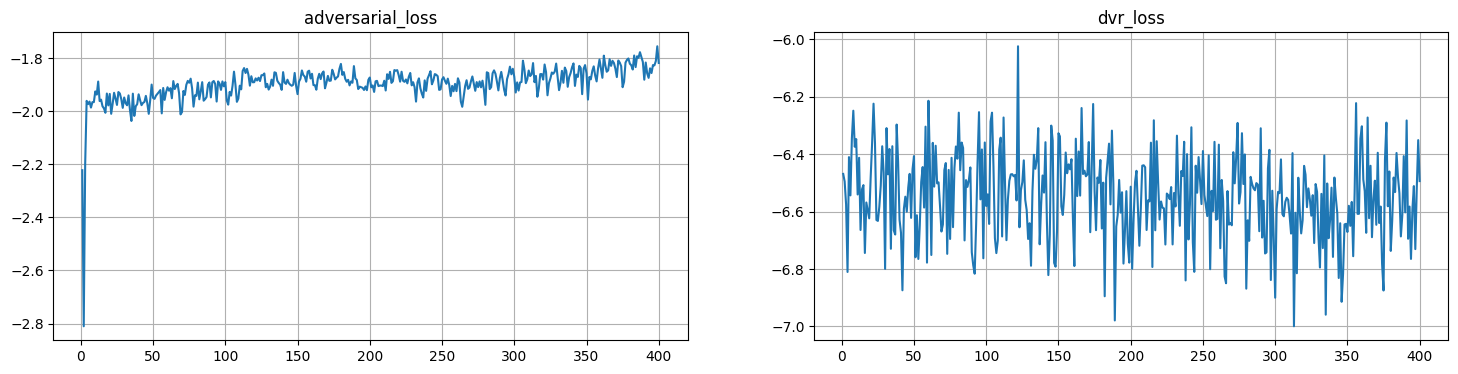

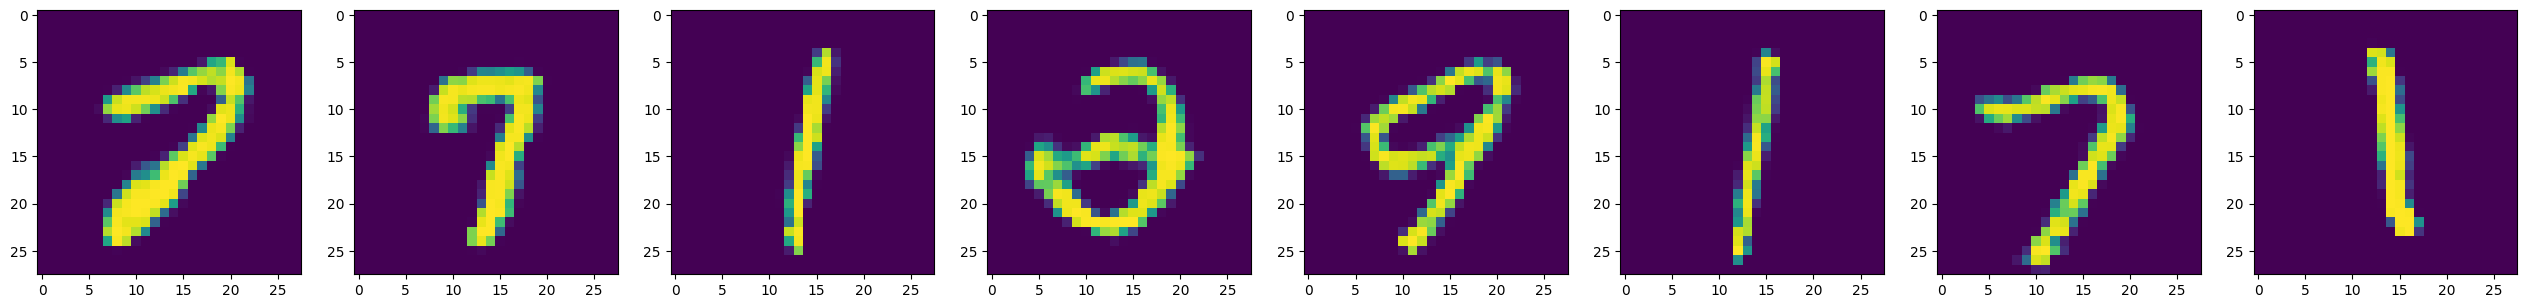

In [27]:
metrics = train(generator_model, discriminator_model, gan_t_model, train_dataloader, device, n_epochs=400)

In [29]:
torch.save(generator_model.state_dict(), "models/generator.pt")
torch.save(discriminator_model.state_dict(), "models/discriminator.pt")
torch.save(gan_t_model.state_dict(), "models/gan_t.pt")

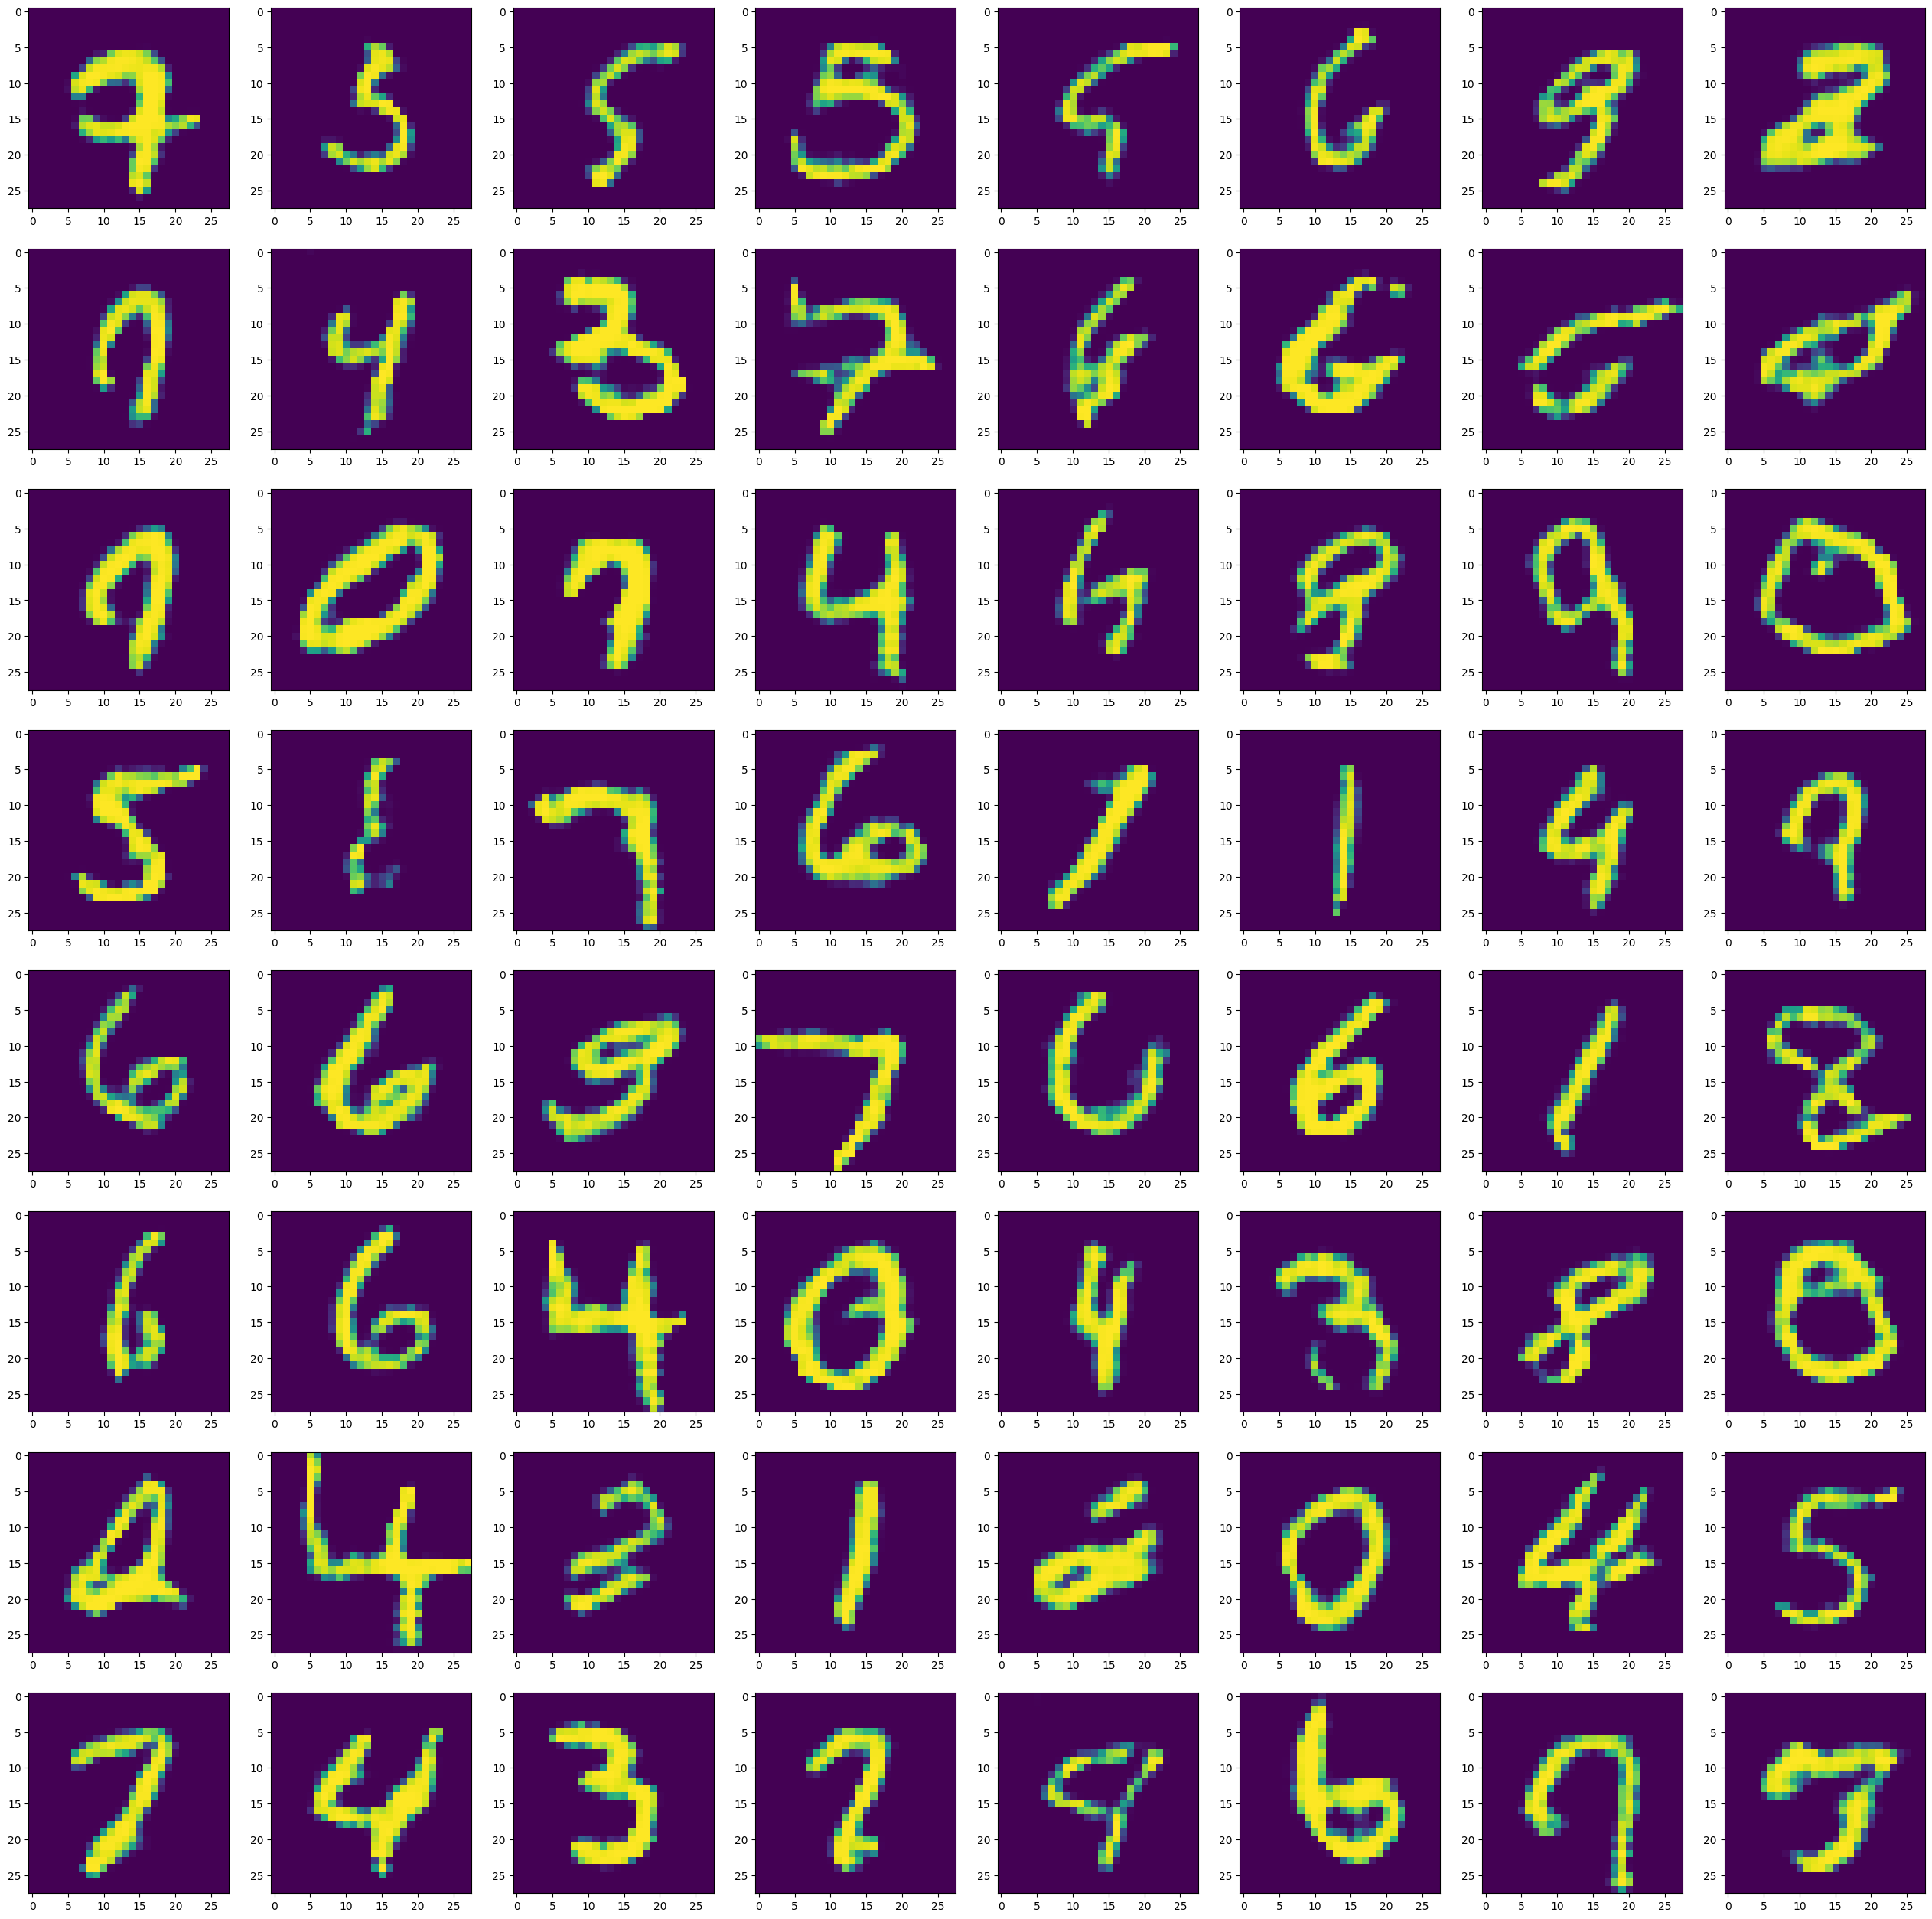

In [34]:
plot_images(generator_model, device, n_rows=8, n_columns=8)